In [15]:
from rdkit import Chem
from rdkit.Chem import Atom, BondType
from rdkit.Chem.Draw import IPythonConsole

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
plasmaa = cm.get_cmap('plasma', 6)
plasmawhite = plasmaa(range(6))
plasmawhite[2] = [1,1,1,1]
# plasmawhite
plasmaW = ListedColormap(plasmawhite)
vmin,vmax = (-2.5,3.5)

In [3]:
def plot_amat(amat):
    # various font sizes
    title_fontsize = 20
    grid_fontsize = 10
    ax_fontsize = 12
    cbar_fontsize = 12

    amat_len = len(amat)
    x = list(range(1,(amat_len+1)))
    y = list(range(1,(amat_len+1)))

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(amat,cmap=plasmaW)

    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))

    ax.set_xticklabels(x,fontname='Arial',fontsize=ax_fontsize)
    ax.set_yticklabels(y,fontname='Arial',fontsize=ax_fontsize)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im.set_clim(vmin, vmax)
    cb = plt.colorbar(im, cax=cax)
    # Minor ticks
    ax.set_xticks(np.arange(-.5, amat_len, 1), minor=True);
    ax.set_yticks(np.arange(-.5, amat_len, 1), minor=True);

    gg = 0.8
    # Gridlines based on minor ticks
    ax.grid(which='minor', color=[gg,gg,gg,1], linestyle='-', linewidth=1)

    cb.ax.tick_params(labelsize=18)
    cb.set_ticks([-2,-1,0,1,2,3])
    cb.ax.set_yticklabels([-2,-1,0,1,2,3],font="Arial",fontsize=cbar_fontsize)

    pass

In [4]:
def amat_entry(amat,r,c,val):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] = amat[c-1][r-1]= val
    return

In [5]:
def amat_edit(amat,r,c,delta):
    """
    changes the (r,c) and (c,r) values of matrix "amat" to "val"
    """
    amat[r-1][c-1] += delta
    if r != c:
        amat[c-1][r-1] += delta
    return

In [6]:
def molFromAdjMat(atoms, amat):
    """Creates a mol object from an adjacency matrix.
    Inputs:
    atoms: list of atomic numbers of atoms, by row
    amat: adjacency matrix. Has to have same length as atoms (obviously)
    Output: mol object
    Might need to add a try clause for sanitize"""
    
    m = Chem.RWMol()
    # add in the separate atoms
    for a in atoms: m.AddAtom(Atom(a))
    side_len = len(amat)    
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order = amat[r][c]
            if bond_order > 0:
                if bond_order == 1: m.AddBond(r,c,BondType.SINGLE)
                if bond_order == 2: m.AddBond(r,c,BondType.DOUBLE)
                if bond_order == 3: m.AddBond(r,c,BondType.TRIPLE)

    Chem.SanitizeMol(m)
    return m

In [7]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

In [12]:
def make_changelogs(data_file_path):
    data = pd.read_csv(data_file_path)[["bond","edit","file"]]
    data = data[~data.bond.isnull()].copy()
    
    changelogs = []
    entry = {}
    bond_edits = ()
    for r in data.itertuples():


        # reset entry dict at new step
        if r[1] == "step":
            entry["edits"] = bond_edits
            changelogs.append(entry)
            entry = {}

        # if padding, fill th
        elif r[1] == "pad":
            pad_atoms = r[3].split(" ")
            pad_atoms = [int(i) for i in pad_atoms]

            if pad_atoms == [0]:
                entry["pad"] = 0
                entry["pad_elem"] = []

            else:
                entry["pad"] = len(pad_atoms)
                entry["pad_elem"] = pad_atoms

            # make the empty bond edits here to prepare
            bond_edits = []
        else:
            bond_edits.append((int(r[1]),int(r[2]),int(r[3])))
    
    return changelogs

In [13]:
def apply_changes(amat_init, atoms_init,changelogs):
    seq_out = [amat_init.copy()]
    amat = amat_init.copy()
    atoms = atoms_init.copy()
    for i in changelogs:
        try:
            
            pad_amt = i["pad"]

            if pad_amt > 0:
                amat = np.pad(amat,[(0, pad_amt), (0, pad_amt)],  mode="constant")
                atoms.extend(i["pad_elem"])

            for ed in i["edits"]:
                amat_edit(amat,ed[0],ed[1],ed[2])
            seq_out.append(amat.copy())
            
        except:
            print(i)
        
    seq_out.reverse()
    
    all_sizes = [m.shape[0] for m in seq_out]
    max_size = max(all_sizes)

    output_padded = []

    for mat in seq_out:
        mat_size = mat.shape[0]
        if mat_size < max_size:
            pad_size = max_size - mat_size 
            output_padded.append(np.pad(mat, [(0, pad_size), (0, pad_size)], mode='constant'))
        else:
            output_padded.append(mat)
            
    return output_padded,atoms

## initialize

In [8]:
target = Chem.MolFromSmiles("C=C1[C@H]([C@]23CC[C@@]4(CCC[C@H]([C@@]42CC[C@@]3(C1)C)C)C)C")

In [9]:
target_atoms = [atm.GetAtomicNum() for atm in target.GetAtoms()]
target_symbs = [atm.GetSymbol() for atm in target.GetAtoms()]

In [10]:
amat = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)
amat_init = Chem.GetAdjacencyMatrix(target,useBO=True,force=True)


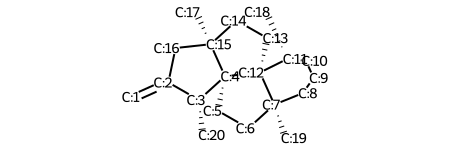

In [11]:
mol_with_atom_index(target)

In [16]:
changelogs = make_changelogs("./edit_files/edits_waihoensene.csv")
changelogs[:3]

[{'edits': ()},
 {'pad': 0,
  'pad_elem': [],
  'edits': [(4, 4, 1),
   (7, 7, 1),
   (12, 12, 1),
   (11, 11, 1),
   (3, 3, 1),
   (15, 15, 1)]},
 {'pad': 2, 'pad_elem': [16, 16], 'edits': [(16, 21, 1), (16, 22, 1)]}]

In [17]:
out_1,final_atoms_1 = apply_changes(amat_init, target_atoms,changelogs[1:])

In [18]:
draw_mols = []
from rdkit.Chem.Draw import *
for i in range(len(out_1)):
    m = molFromAdjMat(final_atoms_1,out_1[i])
    Chem.SanitizeMol(m)
    draw_mols.append(m)
    print(Chem.MolToSmiles(m))

C.C.C.C=CC=CC.CC=CCCCl.CCO.COC1=CC(=O)CC1.I.I.S.S
C.C.C=CC=CC.CC=CCCCl.CCO.COC1=CC(=O)C(C)C1.I.I.S.S
C.C.C.C=CC=CC.CC1CC(=O)C=C1CCO.CC=CCCCl.I.I.O.S.S
C.C.C=CC=CC.CC=C(CCCl)C1(CCO)C(C)CC(=O)C1C.I.I.O.S.S
C.C.C=CC=CC.CC=C(CCI)C1(CCO)C(C)CC(=O)C1C.Cl.I.O.S.S
C.C.C=CC=CC.CC=C1CCC2(C)C(=O)CC(C)C12CCO.Cl.I.I.O.S.S
C.C.C=CC=CC.CC=C1CCC2(C)C(=O)CC(C)C12CCI.Cl.I.O.O.S.S
C.C.C=CC=C(C)CCC12C(=CC)CCC1(C)C(=O)CC2C.Cl.I.I.O.O.S.S
C.C.CC1CC=CC2(C)CCC34C(C)CC(=O)C3(C)CCC124.Cl.I.I.O.O.S.S
C.C.CC1CCCC2(C)CCC34C(C)CC(=O)C3(C)CCC124.Cl.I.I.O.O.S.S
C.C=C1C(=O)C2(C)CCC34C(C)CCCC3(C)CCC24C1C.Cl.I.I.O.O.S.S
C.C=C1C(C)C23CCC4(C)CCCC(C)C42CCC3(C)C1(S)S.Cl.I.I.O.O.O
C.C=C1CC2(C)CCC34C(C)CCCC3(C)CCC24C1C.Cl.I.I.O.O.O.S.S
C.C=C1CC2(C)CCC34C(C)CCCC3(C)CCC24C1C.Cl.I.I.O.O.O.S.S


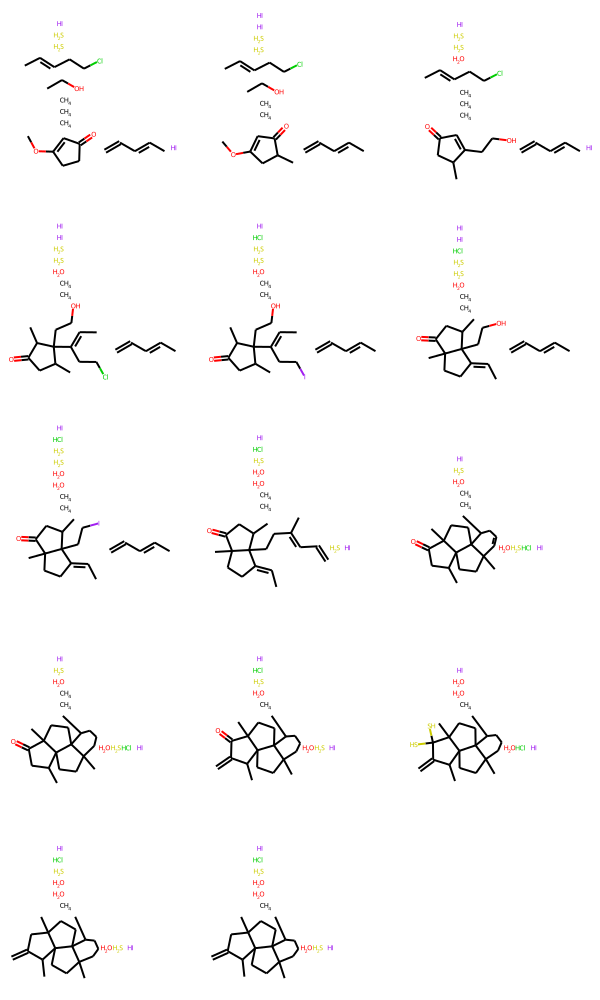

In [19]:
Chem.Draw.MolsToGridImage(draw_mols)

In [20]:
save_dict = {"amats":out_1[:-1],"atoms":final_atoms_1}
np.savez("./matrices/waihoensene_synthia",**save_dict)